In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
import numpy as np
from torch.autograd import functional

In [3]:
from torchdiffeq import odeint

In [4]:
from functools import partial

### Lagrangian of double pendulum

In [5]:
def dpend(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8): # m1, m2, l1, l2 = masses and lengths
    # q = {theta1, theta2}
    # q_dot = {omega1, omega2}
    t1, t2 = q
    w1, w2 = q_dot
    
    # T = kinetic energy
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 + 2 * l1 * l2 * w1 * w2 * torch.cos(t1 - t2))
    
    T = T1 + T2
    
    # V = potential energy
    y1 = -l1 * torch.cos(t1)
    y2 = y1 - l2 * torch.cos(t2)
    V = m1 * g * y1 + m2 * g * y2
    
    return T - V

## Gradient Function

In [6]:
def gradient(function, state):
    q, q_t = torch.split(state, 2) # split state into q, q_t
    gradq = q.clone().detach().requires_grad_(True) 
    gradq_t = q_t.clone().detach().requires_grad_(True) # make q and q_t into tensors with gradient attribute
    func = function(gradq, gradq_t) # set the function
    func.backward() # calculate gradients
    grads = torch.stack((torch.transpose(gradq.grad, 0, -1), torch.transpose(gradq_t.grad, 0, -1)), -1)
    return grads
    # gradq.grad contains the derivatives of function w.r.t. q1 and q2 at [q1, q2, q_t1, q_t2]
    # gradq_t.grad contains the derivatives of function w.r.t. q_t1 and q_t2 at [q1, q2, q_t1, q_t2]

#### Returns
$\begin{pmatrix} \frac{\partial f}{\partial q_1} && \frac{\partial f}{\partial \dot{q}_1} \\ \frac{\partial f}{\partial q_2} && \frac{\partial f}{\partial \dot{q}_2} \end{pmatrix} \Biggr\rvert_{\{q_1, q_2, \dot{q}_1, \dot{q}_2\}}$

### Analytic Solution to the Lagrangian

In [7]:
def f_analytical(t, state, m1=1, m2=1, l1=1, l2=1, g=9.8):
    # state = {theta1, theta2, omega1, omega2}
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(t1 - t2)
    a2 = (l1 / l2) * np.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * np.sin(t1 - t2) - (g/l1) * np.sin(t1)
    f2 = (l1 / l2) * (w1**2) * np.sin(t1 - t2) - (g/l2) * np.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    return torch.Tensor([w1, w2, g1, g2]) # change in t1, t2, w1, w2

Returns:

$$ \begin{pmatrix} \omega_1 \\ \omega_2 \\ \alpha_1 \\ \alpha_2 \end{pmatrix}
$$

### Lagrangian of projectile motion

In [8]:
def fall(x, x_dot):
    a, b = x
    at, bt = x_dot
    m = 2 # mass
    g = 9.8
    return 0.5*m*(at**2 + bt**2) - m*g*b

### Equation of Motion (returns q_tt)

In [8]:
def equation_of_motion(lagrangian, t, state): # state = torch.Tensor([q, q_t])
    q, q_t = torch.split(state, 2)
    hess11 = functional.hessian(lagrangian, (q, q_t))[1][1] # 2 x 2 symmetric matrix with the second partial derivatives of the lagrangian w.r.t. q_t1, q_t2
    hess11inv = torch.linalg.pinv(hess11) # inverse of hess11
    hess10 = functional.hessian(lagrangian, (q, q_t))[1][0] # 2 x 2 matrix with second partial derivatives w.r.t. to all four coordinates in the state
    grad_q = gradient(lagrangian, state) # gradient of f (see above for result)
    grad_q = grad_q[:, 0] # only the q_i components of the gradient
    q_tt = (hess11inv) @ (grad_q - hess10 @ q_t) # returns q_tt
    statet = torch.cat((q_t, q_tt),0)
    return statet.clone().detach().requires_grad_(True) # returns "delta-state": [q_t1, q_t2, q_tt1, q_tt2]

#### Hessian returns:
$$
\begin{pmatrix} \begin{pmatrix} \frac{\partial^2 f}{\partial q_1^2} \frac{\partial^2 f}{\partial q_1 \partial q_2} \\ \frac{\partial^2 f}{\partial q_1 \partial q_2} \frac{\partial^2 f}{\partial q_2^2} \end{pmatrix} && \begin{pmatrix} \frac{\partial^2 f}{\partial q_1 \partial \dot{q}_1} \frac{\partial^2 f}{\partial q_1 \partial\dot{q}_2} \\ \frac{\partial^2 f}{\partial q_2 \partial\dot{q}_1} \frac{\partial^2 f}{\partial q_2 \partial\dot{q}_2} \end{pmatrix} \\ \begin{pmatrix} \frac{\partial^2 f}{\partial \dot{q}_1 \partial q_1} \frac{\partial^2 f}{\partial \dot{q}_1 \partial q_2} \\ \frac{\partial^2 f}{\partial \dot{q}_2 \partial q_1} \frac{\partial^2 f}{\partial \dot{q}_2 \partial q_2} \end{pmatrix} && \begin{pmatrix} \frac{\partial^2 f}{\partial \dot{q}_1^2} \frac{\partial^2 f}{\partial \dot{q}_1 \partial\dot{q}_2} \\ \frac{\partial^2 f}{\partial \dot{q}_1 \partial\dot{q}_2} \frac{\partial^2 f}{\partial \dot{q}_2^2} \end{pmatrix}\end{pmatrix} \Biggr\rvert_{\{q_1, q_2, \dot{q}_1, \dot{q}_2\}}
$$

### Use Lagrangian to get Equations of Motion

In [9]:
def solve_lagrangian(lagrangian, initial_state, t):
    def f(initial_state):
        equation_of_mot = partial(equation_of_motion, lagrangian)
        return odeint(equation_of_mot, initial_state, t)
    
    return f(initial_state)

In [10]:
def solve_autograd(lagrangian, initial_state, times):
    return solve_lagrangian(lagrangian, initial_state, t=times)

### Test with projectile motion

In [12]:
x0 = torch.Tensor([0, 0, 5, 100]) # initial conditions: [x_0 = 0, y_0 = 20, vx_0 = 5, vy_0 = 40]
t = torch.linspace(0, 20, steps=1001, dtype=torch.float32) # times: 0 - 10 seconds, 0.01 second intervals

In [13]:
projectile_autograd = solve_autograd(fall, x0, t) # solve q_tt

In [14]:
npx = projectile_autograd.detach().numpy() # convert torch.tensor result to np.array

In [15]:
# normal/analytic projectile
times = np.linspace(0, 20, 1001)

x = []
y = []
for time in times:
    x.append(x0[0].item() + x0[2].item() * time)
    y.append(x0[1].item() + x0[3].item() * time - 4.9 * time**2)

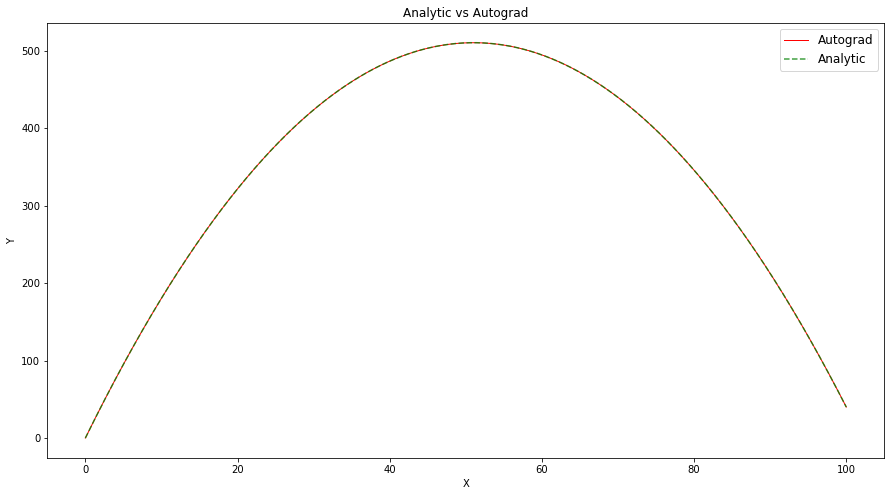

In [16]:
plt.figure(figsize=[15, 8])
plt.title("Analytic vs Autograd")
plt.xlabel("X")
plt.ylabel("Y")

plt.plot(npx[:,0], npx[:, 1], 'r-', lw = 1, alpha = 1, label = 'Autograd')
plt.plot(x, y, 'g--', ms = 0.5, alpha = 0.75, label = 'Analytic')

plt.legend(fontsize=12)

### Test with Double Pendulum

In [60]:
pend0 = torch.Tensor([np.pi/2, np.pi/2, 0, 0]) # initial conditions: [theta1, theta2, w1, w2]
pendt = torch.linspace(0, 25, steps=501, dtype=torch.float32) # times: 0 - 25 seconds, 0.05 second intervals

In [18]:
x_autograd = solve_autograd(dpend, pend0, pendt) # integrate theta_tt

In [19]:
pendx = x_autograd.detach().numpy() # convert torch.tensor result to np.array

In [11]:
def solve_analytical(initial_state, times): # solve double pendulum using analytical formula
    return odeint(f_analytical, initial_state, t=times)

In [13]:
analytical_pend = solve_analytical(pend0, pendt)

NameError: name 'pend0' is not defined

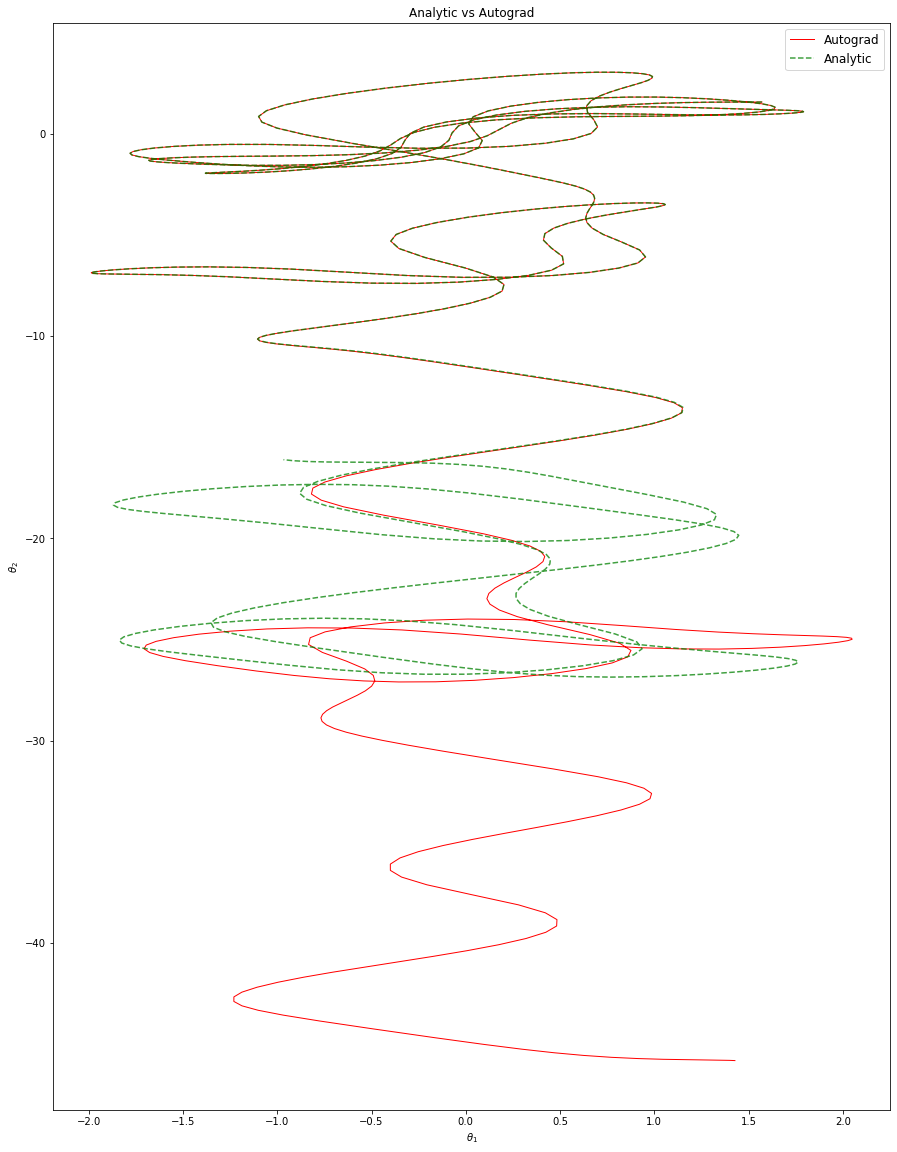

In [22]:
plt.figure(figsize=[15, 20])

plt.title("Analytic vs Autograd")
plt.xlabel("$\\theta_1$")
plt.ylabel("$\\theta_2$")

plt.plot(pendx[:,0], pendx[:, 1], 'r-', lw = 1, alpha = 1, label = 'Autograd')
plt.plot(analytical_pend[:,0], analytical_pend[:,1], 'g--', ms = 0.5, alpha = 0.75, label = 'Analytic')

plt.legend(fontsize=12)

### Create GIFs

In [23]:
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [24]:
# Plotting Functions

def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
 
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
    x1 = l1 * np.sin(t1)
    y1 = -l1 * np.cos(t1)
    x2 = x1 + l2 * np.sin(t2)
    y2 = y1 - l2 * np.cos(t2)
    return x1, y1, x2, y2

def fig2image(fig):
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

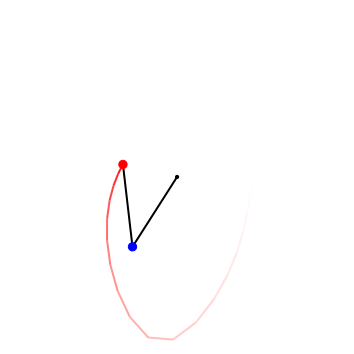

In [25]:
# Analytic Pendulum GIF

L1, L2 = 1, 1
theta1, theta2 = analytical_pend[:, 0], analytical_pend[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

animages = []
di = 1
N = 300
for i in range(0, N, di):
    make_plot(i, cart_coords, L1, L2)
    animages.append( fig2image(fig))

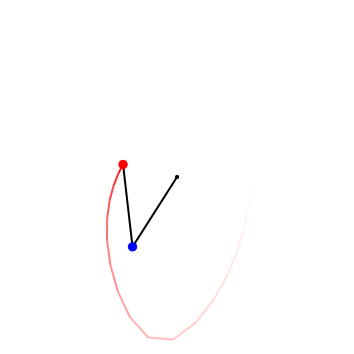

In [26]:
# Autograd Pendulum GIF


autheta1, autheta2 = pendx[:, 0], pendx[:, 1]
aucart_coords = radial2cartesian(autheta1, autheta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

warnings.filterwarnings("ignore")

auimages = []
di = 1
N = 300
for i in range(0, N, di):
    make_plot(i, aucart_coords, L1, L2)
    auimages.append( fig2image(fig) )

In [27]:
import imageio

imageio.mimsave('anpend.gif', animages)
imageio.mimsave('aupend.gif', auimages)

<img src="anpend.gif" width="300" align="left"> <img src="aupend.gif" width="300" align="right"> 

### Create Training Data Using Analytical Solution

In [286]:
time_step = 0.01
N = 100

train0 = torch.Tensor([3*np.pi/5, 3*np.pi/4, 0, 0])
traint = torch.linspace(0, 1, N, dtype=torch.float32)
x_train = solve_analytical(train0, traint)


In [287]:
xt_train = torch.stack([f_analytical(traint.cpu(), x.cpu()) for x in x_train])

test0 = torch.Tensor([2*np.pi/3, 1*np.pi/4, 0, 0])
testt = torch.linspace(0, 2, 100, dtype=torch.float32)
x_test = solve_analytical(test0, testt)
xt_test = torch.stack([f_analytical(testt, x) for x in x_test])

In [288]:
def normalize(state): # constrain theta to [-pi, pi]
    return torch.cat([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

In [289]:
# create new training set with all values of theta in [-pi, pi]
x_train = torch.stack([normalize(x) for x in x_train])
x_test = torch.stack([normalize(x) for x in x_test])

In [275]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train

In [17]:
from scipy.integrate import solve_ivp

In [227]:
class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lag(self, x): 
        x = nn.functional.softmax(self.fc1(x), dim = 0)
        x = nn.functional.softmax(self.fc2(x), dim = 0)
        x = self.fc3(x)
        return x 

    def forward(self, x):
        #print(x.shape)
        #print(x)
        if len(x.shape) >= 2:
            n = x.shape[1]//2
        else:
            n = x.shape[0]//2
        xv = x.clone().detach().requires_grad_(True) 
        xv_tup = tuple([xi for xi in x]) 

        tqt = xv[:, n:]


        jacpar = partial(functional.jacobian,  self.lag, create_graph=True)
        hesspar = partial(functional.hessian,  self.lag, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))

        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))

        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)



    
def msloss(pred, targ):
    return torch.mean((pred - targ)**2)

def nn_solve_ode(model, t, x0):
    print(x0)
    def f(t, x):
        print(x)
        return model(x)
    return odeint(f, x0, t, rtol=1e-10, atol=1e-10, method='rk4')  

In [154]:
model = LNN()

In [111]:
x_train = x_train.to(device='cuda')
xt_train = xt_train.to(device='cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [157]:
model = LNN().to(device)

In [292]:
eps = 1000
N = 100
batch_size = 50



optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_list = []
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 750, 900], gamma=0.5)
for e in range(eps):

    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = x_train[(i-1)*batch_size:i*batch_size]
        #xi = xi.to(device='cuda')
        xt_pred = model(xi)
        xtt_pred = torch.split(xt_pred, 2, -1)[1]
        #print(xt_pred, xt_train[(i-1)*batch_size:i*batch_size])
        targ_xtt = torch.split(xt_train[(i-1)*batch_size:i*batch_size], 2, -1)[1]
        loss_val = msloss(xtt_pred, targ_xtt)
        loss_val.backward()

        optimizer.step()



        running_loss += loss_val.item()

    scheduler.step()    
    print('[%d, %5d] loss: %.10f' %
          (e + 1, i + 1, running_loss/(N // batch_size)))
    loss_list.append(running_loss/(N // batch_size))
    running_loss = 0.0

[1,     2] loss: 0.0567565635
[2,     2] loss: 0.0497621521
[3,     2] loss: 0.0464673787
[4,     2] loss: 0.0461247526
[5,     2] loss: 0.0470133722
[6,     2] loss: 0.0475131311
[7,     2] loss: 0.0471363068
[8,     2] loss: 0.0461984649
[9,     2] loss: 0.0451876633
[10,     2] loss: 0.0444447286
[11,     2] loss: 0.0440722033
[12,     2] loss: 0.0439657867
[13,     2] loss: 0.0439269170
[14,     2] loss: 0.0437847152
[15,     2] loss: 0.0434647948
[16,     2] loss: 0.0429922529
[17,     2] loss: 0.0424516350
[18,     2] loss: 0.0419372097
[19,     2] loss: 0.0415141955
[20,     2] loss: 0.0411990322
[21,     2] loss: 0.0409629233
[22,     2] loss: 0.0407539383
[23,     2] loss: 0.0405251458
[24,     2] loss: 0.0402510129
[25,     2] loss: 0.0399301387
[26,     2] loss: 0.0395780429
[27,     2] loss: 0.0392155647
[28,     2] loss: 0.0388612412
[29,     2] loss: 0.0385275856
[30,     2] loss: 0.0382182002
[31,     2] loss: 0.0379299372
[32,     2] loss: 0.0376536511
[33,     2] loss:

KeyboardInterrupt: 

In [266]:
torch.save(model.state_dict(), 'model_weights.pth')

In [290]:
model.load_state_dict(torch.load('model_weights.pth', device))
model.eval()

LNN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [311]:
t1 = torch.linspace(0, 2, 500)

nn_test1 = nn_solve_ode(model, t1, x_test[0, None])




tensor([[2.0944, 0.7854, 0.0000, 0.0000]])
tensor([[2.0944, 0.7854, 0.0000, 0.0000]])
tensor([[ 2.0944,  0.7854, -0.0124,  0.0022]], grad_fn=<AddBackward0>)
tensor([[ 2.0943,  0.7854, -0.0247,  0.0044]], grad_fn=<AddBackward0>)
tensor([[ 2.0943,  0.7854, -0.0371,  0.0066]], grad_fn=<AddBackward0>)
tensor([[ 2.0943,  0.7854, -0.0371,  0.0066]], grad_fn=<AddBackward0>)
tensor([[ 2.0943,  0.7854, -0.0495,  0.0088]], grad_fn=<AddBackward0>)
tensor([[ 2.0942,  0.7854, -0.0619,  0.0109]], grad_fn=<AddBackward0>)
tensor([[ 2.0941,  0.7854, -0.0743,  0.0131]], grad_fn=<AddBackward0>)
tensor([[ 2.0941,  0.7855, -0.0743,  0.0131]], grad_fn=<AddBackward0>)
tensor([[ 2.0940,  0.7855, -0.0868,  0.0153]], grad_fn=<AddBackward0>)
tensor([[ 2.0938,  0.7855, -0.0992,  0.0175]], grad_fn=<AddBackward0>)
tensor([[ 2.0937,  0.7855, -0.1116,  0.0197]], grad_fn=<AddBackward0>)
tensor([[ 2.0937,  0.7855, -0.1116,  0.0197]], grad_fn=<AddBackward0>)
tensor([[ 2.0936,  0.7855, -0.1241,  0.0218]], grad_fn=<AddBac

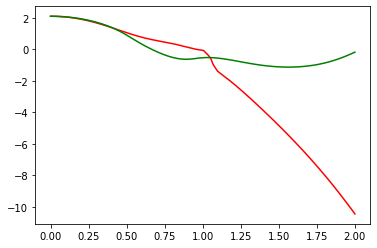

In [312]:
plt.plot(t1, nn_test1[:, 0][:, 0].detach().numpy(), c='r')

plt.plot(testt, x_test[:, 0], c='g')

In [293]:
xtt = model(x_train)

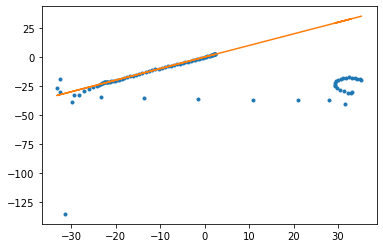

In [305]:
plt.plot(xt_train[:,3].detach().numpy(), xtt[:,3].detach().numpy(), '.')
plt.plot(xt_train[:,3].detach().numpy(), xt_train[:,3].detach().numpy())

In [308]:
xt_train, xtt

(tensor([[ 0.0000e+00,  0.0000e+00, -1.0336e+01,  2.2798e+00],
         [-1.0439e-01,  2.2994e-02, -1.0333e+01,  2.2696e+00],
         [-2.0872e-01,  4.5782e-02, -1.0322e+01,  2.2389e+00],
         [-3.1290e-01,  6.8154e-02, -1.0305e+01,  2.1873e+00],
         [-4.1688e-01,  8.9898e-02, -1.0281e+01,  2.1143e+00],
         [-5.2057e-01,  1.1079e-01, -1.0249e+01,  2.0192e+00],
         [-6.2389e-01,  1.3061e-01, -1.0209e+01,  1.9010e+00],
         [-7.2677e-01,  1.4912e-01, -1.0161e+01,  1.7587e+00],
         [-8.2913e-01,  1.6606e-01, -1.0104e+01,  1.5912e+00],
         [-9.3086e-01,  1.8117e-01, -1.0038e+01,  1.3975e+00],
         [-1.0319e+00,  1.9420e-01, -9.9629e+00,  1.1767e+00],
         [-1.1321e+00,  2.0485e-01, -9.8785e+00,  9.2762e-01],
         [-1.2314e+00,  2.1284e-01, -9.7847e+00,  6.4967e-01],
         [-1.3297e+00,  2.1787e-01, -9.6815e+00,  3.4224e-01],
         [-1.4270e+00,  2.1965e-01, -9.5692e+00,  4.9996e-03],
         [-1.5230e+00,  2.1787e-01, -9.4482e+00, -3.621